In [1]:
%matplotlib inline

In [2]:
from zipfile import ZipFile
import json
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from cygrid import WcsGrid
import pyweaver

In [3]:
imkw = dict(origin='lower', interpolation='nearest')

In [4]:
with ZipFile('sn1572.zip') as myzip:
    with myzip.open('sn1572_lon.json') as f:
        data1 = json.load(f)
    with myzip.open('sn1572_lat.json') as f:
        data2 = json.load(f)

In [5]:
poly_order = (4, 4)
beam_fwhm = 63.3 / 3600  # degrees
kernel_sigma = beam_fwhm / 2 / np.sqrt(8 * np.log(2))
kernel_params = (
    'gauss1d', (kernel_sigma, ), 3 * kernel_sigma, kernel_sigma / 2
    )

In [6]:
mapcenter = 6.3396, 64.140833
map_size = 0.2, 0.2
pixel_size = beam_fwhm / 6
naxis1 = int(map_size[0] / pixel_size + 0.5)
naxis2 = int(map_size[1] / pixel_size + 0.5)

In [7]:
map_header = {
    'NAXIS': 3,
    'NAXIS1': naxis1,
    'NAXIS2': naxis2,
    'NAXIS3': 1,  # need dummy spectral axis
    'CTYPE1': 'RA---SIN',
    'CTYPE2': 'DEC--SIN',
    'CUNIT1': 'deg',
    'CUNIT2': 'deg',
    'CDELT1': -pixel_size,
    'CDELT2': pixel_size,
    'CRPIX1': naxis1 / 2.,
    'CRPIX2': naxis2 / 2.,
    'CRVAL1': mapcenter[0],
    'CRVAL2': mapcenter[1],
    }

In [8]:
map_wcs = WCS(map_header)

In [9]:
lons1 = [data1[sub]['lon'] for sub in data1]
lats1 = [data1[sub]['lat'] for sub in data1]
dirty1 = [data1[sub]['data'] for sub in data1]
lons2 = [data2[sub]['lon'] for sub in data2]
lats2 = [data2[sub]['lat'] for sub in data2]
dirty2 = [data2[sub]['data'] for sub in data2]

In [10]:
map1, wmap1, bw_maps1, map2, wmap2, bw_maps2 = pyweaver.compute_maps(
    lons1, lats1, dirty1,
    lons2, lats2, dirty2,
    map_header,
    kernel_params,
    poly_order=poly_order,
    )

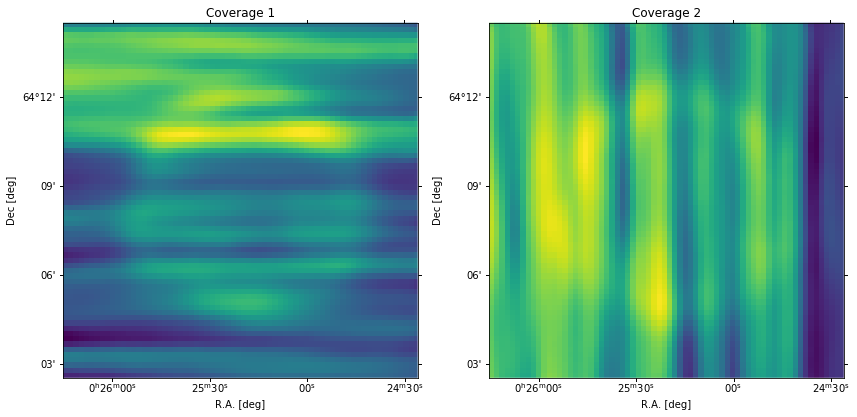

In [11]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(121, projection=map_wcs.celestial)
ax2 = fig.add_subplot(122, projection=map_wcs.celestial)
ax1.imshow(map1, **imkw)
ax2.imshow(map2, **imkw)
ax1.set_title('Coverage 1')
ax2.set_title('Coverage 2')
for ax in ax1, ax2:
    lon, lat = ax.coords
    lon.set_axislabel('R.A. [deg]')
    lat.set_axislabel('Dec [deg]')

plt.show()

Now, do the actual basket-weaving. First create the necessary matrices

In [12]:
bw_mat, bw_mat_recon = pyweaver.compute_bw_matrices(
    bw_maps1, wmap1, bw_maps2, wmap2,
    poly_order=poly_order, dampening=0.1,
    )

Now solve the problem, also get a correction map in the process

In [13]:
diff_map = map1 - map2
poly_coeffs, correction_map, fit_map = pyweaver.solve_bw(
    bw_mat, bw_mat_recon, diff_map
    )

/home/bwinkel/local/miniconda3new/envs/cygrid-test-3.6/lib/python3.6/site-packages/pyweaver-0.1.0.dev15-py3.6.egg/pyweaver/weaver.py:187: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  presult = np.linalg.lstsq(A, dirty_vec)


In [14]:
dirty_map = (map1 * wmap1 + map2 * wmap2) / (wmap1 + wmap2)
cleaned_map = dirty_map - correction_map

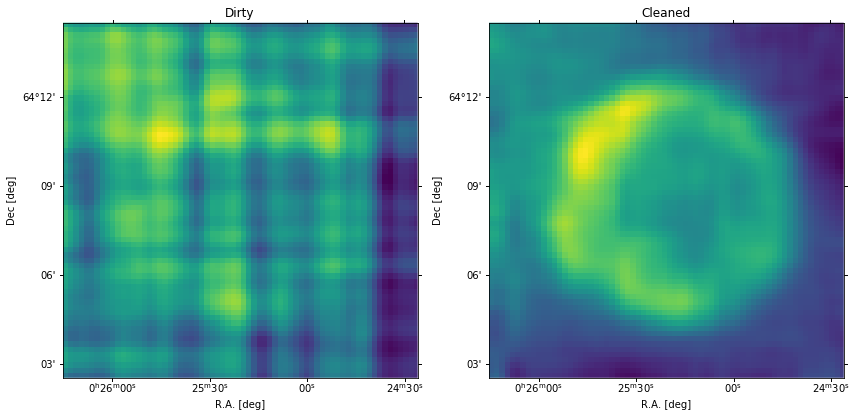

In [15]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(121, projection=map_wcs.celestial)
ax2 = fig.add_subplot(122, projection=map_wcs.celestial)
ax1.imshow(dirty_map, **imkw)
ax2.imshow(cleaned_map, **imkw)
ax1.set_title('Dirty')
ax2.set_title('Cleaned')
for ax in ax1, ax2:
    lon, lat = ax.coords
    lon.set_axislabel('R.A. [deg]')
    lat.set_axislabel('Dec [deg]')

plt.show()